# (24) ca awake -- affine

**Motivation**: See if affine transforms work. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = os.path.join(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def _invert_lr(img, arr=None):
    if arr is None:
        arr = img.numpy()
    return reset_ants_img(
        img=arr[:, ::-1],
        spacing=img.spacing,
        origin=img.origin,
        dtype=img.dtype,
        use_um=False,
    )


def _load_fx(sub: int, sharp_mask: bool = False):
    fx = f'sub-SLC{sub:02d}_ses-4_space-individual_desc-referenceimage_ca2.nii.gz'
    fx = ants.image_read(pjoin(mice.cfg.raw_dir, fx))
    fx = _invert_lr(fx)
    m_fx = f'sub-SLC{sub:02d}_ses-4_space-individual_desc-mask_ca2.nii.gz'
    m_fx = ants.image_read(pjoin(mice.cfg.raw_dir, m_fx))
    m_fx = _invert_lr(
        img=m_fx,
        arr=m_fx.numpy() == 1.0 if
        sharp_mask else m_fx.numpy()
    )
    return fx, m_fx


def _load_mv(sub: int, ses: int, sharp_mask: bool = False):
    mv = f'sub-SLC{sub:02d}_ses-{ses}_space-individual_desc-referenceimage_ca2.nii.gz'
    mv = ants.image_read(pjoin(mice.cfg.raw_dir, mv))
    mv = reset_ants_img(
        img=mv.numpy()[..., 0],
        spacing=mv.spacing[:2],
        origin=mv.origin[:2],
        dtype=mv.dtype,
        use_um=False,
    )
    m_mv = f'sub-SLC{sub:02d}_ses-{ses}_space-individual_desc-mask_ca2.nii.gz'
    m_mv = ants.image_read(pjoin(mice.cfg.raw_dir, m_mv))
    m_mv = reset_ants_img(
        img=rescale(
            m_mv.numpy() == 1.0 if
            sharp_mask else m_mv.numpy(), 2),
        spacing=mv.spacing,
        origin=mv.origin,
        dtype=mv.dtype,
        use_um=False,
    )
    return mv, m_mv


def _load_obj(sub: int, ses: int, obj: str = 'cols'):
    mv, _ = _load_mv(sub, ses)
    obj = f'sub-SLC{sub:02d}_ses-{ses}_space-indiv2d_{obj}.nii.gz'
    obj = ants.image_read(pjoin(mice.cfg.masks_dir, obj))
    obj = reset_ants_img(
        img=obj.numpy()[..., 0],
        spacing=mv.spacing,
        origin=mv.origin,
        dtype='uint32',
        use_um=False,
    )
    return obj


def _show_ref_overlay(x, mask, overlay, bound: int = 512):
    m = mask.numpy()
    x2p = filter_boundaries(x.numpy() * m, m)
    
    fig, axes = create_figure(1, 3, (7.8, 3.0), 'all', 'all', 'constrained')
    remove_ticks(axes)
    for ax in axes.flat:
        ax.imshow(x2p, cmap='Greys_r')

    axes[1].set_title('left hemis')
    axes[2].set_title('right hemis')

    x2p = filter_boundaries(overlay.numpy(), m)
    x2p = mwh(~np.logical_and(1 < x2p, x2p < bound), x2p)
    axes[1].imshow(x2p, cmap='Spectral', interpolation='none')

    x2p = filter_boundaries(overlay.numpy(), m)
    x2p = mwh(x2p < bound, x2p)
    axes[2].imshow(x2p, cmap='Spectral', interpolation='none')

    plt.show()


def _show_ref(sub):
    fx, m_fx = _load_fx(sub)

    fig, axes = create_figure(2, 2, (7, 7), 'all', 'all', 'constrained')
    ax = axes.flat[-1]
    ax.set_title("awake")
    x2p = mwh(~m_fx.numpy().astype(bool), fx.numpy())
    ax.imshow(x2p, cmap='Greys_r')

    for i in range(3):
        ax = axes.flat[i]
        ax.set_title(f"ses-{i+1}")
        mv, m_mv  = _load_mv(sub, i + 1)
        x2p = mwh(~m_mv.numpy().astype(bool), mv.numpy())
        ax.imshow(x2p, cmap='Greys_r')

    plt.show()

    
def _get_op(sub):
    if sub in [2, 6]:
        def _op(img, arr=None):
            if arr is None:
                arr = img.numpy()
            #############################
            arr = arr.T
            arr = arr[::-1]
            #############################
            return reset_ants_img(
                img=arr,
                spacing=img.spacing,
                origin=img.origin,
                dtype=img.dtype,
                use_um=False,
            )
    else:
        return
    return _op


def _fit_rigid(sub: int, n_seeds: int = 20, verbose: bool = True):
    fx, m_fx = _load_fx(sub)
    mi_base = ants.image_mutual_information(
        image1=fx * m_fx, image2=fx * m_fx)
    op = _get_op(sub)
    df = []
    best_tx = None
    best_mi = -np.inf
    best_ses = None
    pbar1 = tqdm(
        range(1, 3 + 1),
        disable=not verbose,
        leave=True,
    )
    for ses in pbar1:
        mv, m_mv = _load_mv(sub, ses)
        if op is not None:
            mv, m_mv = map(op, [mv, m_mv])
        pbar2 = tqdm(
            range(n_seeds),
            disable=not verbose,
            leave=False,
        )
        for seed in pbar2:
            _tx = ants.registration(
                fixed=fx * m_fx,
                moving=mv * m_mv,
                type_of_transform='DenseRigid',
                random_seed=seed,
            )
            mi = ants.image_mutual_information(
                image1=fx * m_fx,
                image2=_tx['warpedmovout'],
            ) / mi_base
            df.append({
                'sub': [sub],
                'ses': [ses],
                'seed': [seed],
                'mi': [mi],
            })
            if mi > best_mi:
                best_mi = mi
                best_tx = _tx.copy()
                best_ses = ses
    df = pd.DataFrame(merge_dicts(df))
    assert df.iloc[df['mi'].argmax()]['mi'] == best_mi
    return best_ses, best_tx, df


def _fit_affine(
    fixed: ants.ANTsImage,
    moving: ants.ANTsImage,
    t_type: str = 'Similarity',
    n_seeds: int = 20,
    verbose: bool = True, ):
    mi_base = ants.image_mutual_information(
        image1=fixed, image2=fixed)

    best_tx = None
    best_mi = -np.inf
    pbar = tqdm(
        range(n_seeds),
        disable=not verbose,
        leave=True,
    )
    for seed in pbar:
        _tx = ants.registration(
            fixed=fixed,
            moving=moving,
            type_of_transform=t_type,
            random_seed=seed,
        )
        mi = ants.image_mutual_information(
            image1=fixed,
            image2=_tx['warpedmovout'],
        ) / mi_base
        if mi > best_mi:
            best_mi = mi
            best_tx = _tx.copy()
    return best_tx, best_mi


from register.register import reset_ants_img
from skimage.transform import rescale, resize

In [3]:
mice = Mice(512)

## Which subs

In [5]:
files = sorted(filter(
    lambda s: 'awake' in s,
    os.listdir(mice.cfg.raw_dir),
))
subs = [
    int(re.findall(r'\d+', f.split('_')[0]).pop())
    for f in files
]
subs = [
    k for k, v in collections.Counter(subs).items()
    if k <= 10 and v >= 9
]
subs

[2, 6, 7, 9, 10]

## Fit Rigid + Similarity

In [6]:
%%time

t_type = 'Similarity'

df = []
cols_aff = {}
for sub in subs:
    op = _get_op(sub)
    fx, m_fx = _load_fx(sub)
    best_ses, best_tx_rigid, _ = _fit_rigid(
        sub=sub, verbose=False)
    cols = _load_obj(sub, best_ses)
    cols_rig = ants.apply_transforms(
        fixed=fx * m_fx,
        moving=cols if op is None else op(cols),
        transformlist=best_tx_rigid['fwdtransforms'],
        interpolator='genericLabel',
    )
    best_tx_aff, best_mi = _fit_affine(
        fixed=fx * m_fx,
        moving=best_tx_rigid['warpedmovout'],
        t_type=t_type,
        verbose=False,
    )
    cols_aff[sub] = ants.apply_transforms(
        fixed=fx * m_fx,
        moving=cols_rig,
        transformlist=best_tx_aff['fwdtransforms'],
        interpolator='genericLabel',
    )
    df.append({
        'sub': [sub],
        'ses': [best_ses],
        't_type': [t_type],
        'mi': [best_mi],
    })
df = pd.DataFrame(merge_dicts(df))

CPU times: user 3h 24min 42s, sys: 8min 13s, total: 3h 32min 56s
Wall time: 12min 55s


In [7]:
df

,sub,ses,t_type,mi
0,2,1,Similarity,0.601568
1,6,2,Similarity,0.526474
2,7,1,Similarity,0.543938
3,9,1,Similarity,0.622083
4,10,1,Similarity,0.626669


sub 02,  type: Similarity,   mi = 0.6016

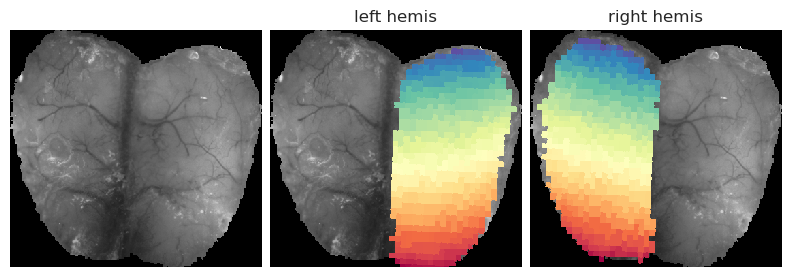

sub 06,  type: Similarity,   mi = 0.5265

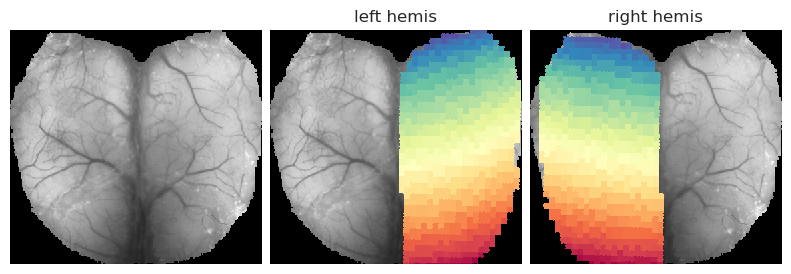

sub 07,  type: Similarity,   mi = 0.5439

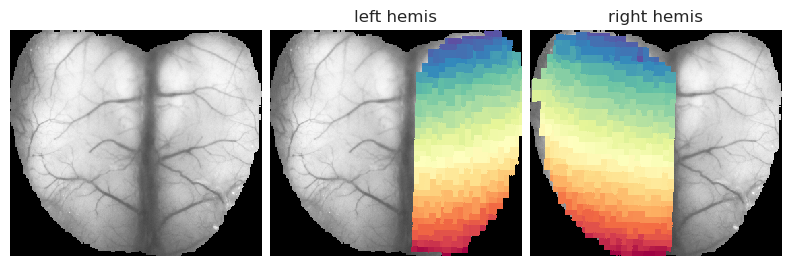

sub 09,  type: Similarity,   mi = 0.6221

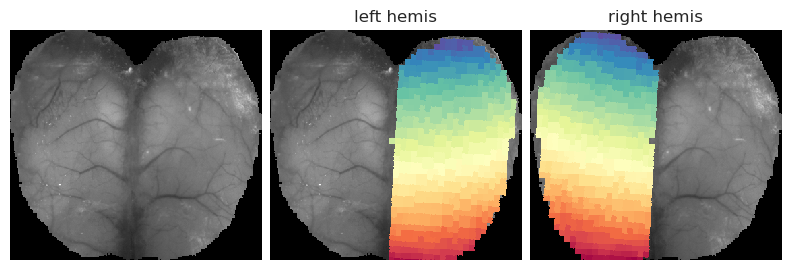

sub 10,  type: Similarity,   mi = 0.6267

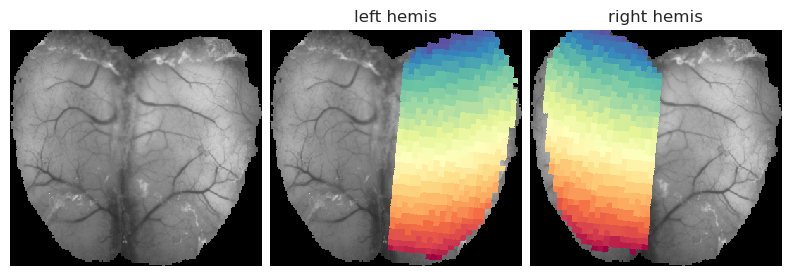

In [10]:
for sub, x in cols_aff.items():
    mi = df.loc[df['sub'] == sub, 'mi'].values.item()
    print(f"sub {sub:02d},  type: {t_type},   mi = {mi:0.4f}")

    fx, m_fx = _load_fx(sub)
    fx, m_fx, xx = map(_invert_lr, [fx, m_fx, x])
    _show_ref_overlay(fx, m_fx, xx)

    fname = '_'.join([
        f"sub-SLC{sub:02d}",
        'ses-4',
        'space-indiv2d',
        'cols',
    ])
    fname = f"{fname}.nii.gz"
    fname = pjoin(mice.cfg.masks_dir, fname)
    ants.image_write(xx, fname)